In [1]:
import gc
import torch

torch.backends.cudnn.benchmark =  True
def clean_my_cuda():
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                del(obj)
        except:
            pass

    gc.collect()
    torch.cuda.empty_cache()

# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>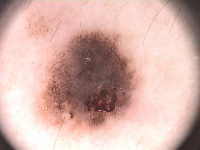</td><td>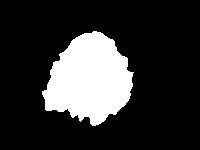</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [2]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'big_data_folder'

for root, dirs, files in os.walk(os.path.join(root, 'images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [3]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [5]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

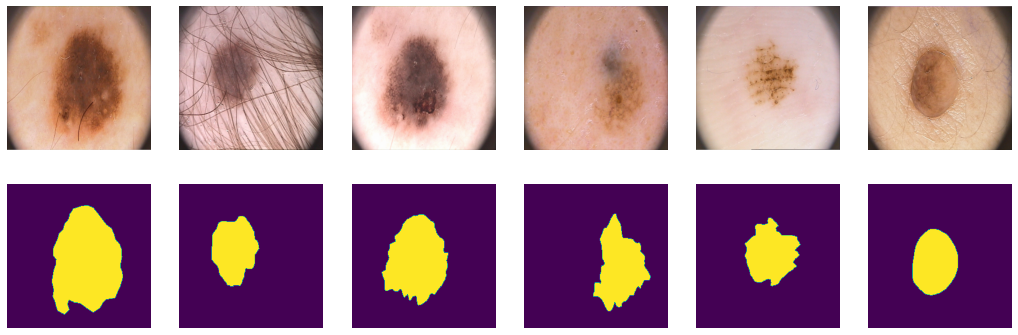

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True, pin_memory=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

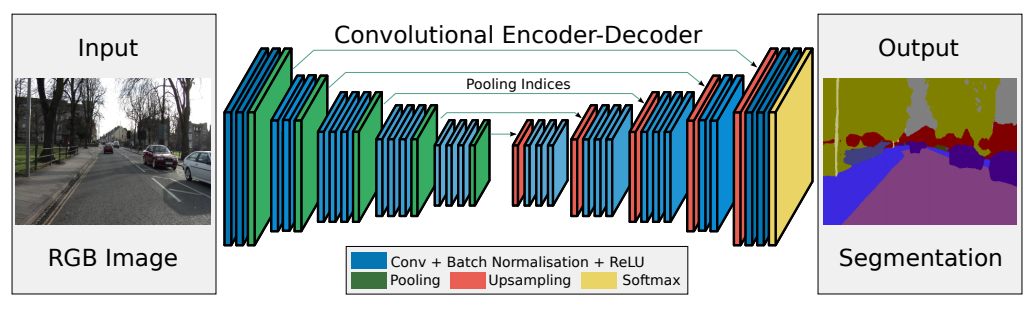

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [12]:
class SegNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.activation = nn.ReLU()
        
        # encoder (downsampling)
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(32),
            self.activation,
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(32),                                        
            self.activation)
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # h,w 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(64),
            self.activation,
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
             nn.BatchNorm2d(64),                                        
            self.activation)

        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # h,w 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),
            self.activation,
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),                                        
            self.activation,
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),                                        
            self.activation)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # h,w 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(256),
            self.activation,
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(256),                                        
            self.activation,
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(256),                                        
            self.activation)

        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # h,w 32 -> 16

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(256),
            self.activation,
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(256),
            self.activation,
            
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),
            self.activation)
                                       
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # h,w 32 -> 64
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),
            self.activation,
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),
            self.activation,
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(64),
            self.activation)
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # h,w 64 -> 128
        
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(64),
            self.activation,
            
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(32),
            self.activation)
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # h,w 128 -> 256
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(32),
            self.activation,
            
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, padding_mode='zeros'))
        
        
        

    def forward(self, x):
        # note that activations are inside of self.xxx_convx
        
        # encoder
        enc0, indices_0 = self.pool0(self.enc_conv0(x))
        enc1, indices_1 = self.pool1(self.enc_conv1(enc0))
        enc2, indices_2 = self.pool2(self.enc_conv2(enc1))
        enc3, indices_3 = self.pool3(self.enc_conv3(enc2))

        # decoder
        dec0 = self.dec_conv0(self.upsample0(enc3, indices_3))
        dec1 = self.dec_conv1(self.upsample1(dec0, indices_2))
        dec2 = self.dec_conv2(self.upsample2(dec1, indices_1))
        dec3 = self.dec_conv3(self.upsample3(dec2, indices_0))
        
        return dec3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [13]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    
    outputs = outputs.byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0
    
    return iou

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [14]:
def bce_loss(y_true, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    return (y_pred - y_true*y_pred + torch.log(1+torch.exp(-y_pred))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [92]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler = None, verbose = True, return_losses = False):
    
    val_losses = []
    train_losses = []
    
    for epoch in range(epochs):
        
        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:

            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            avg_loss += loss.item() / len(data_tr)
            
        train_losses.append(avg_loss)  
        
        
        avg_loss = 0
        model.eval()  # testing mode
        with torch.no_grad():
            for X_batch, Y_batch in data_val:
                
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred = model(X_batch)
                loss = loss_fn(Y_batch, Y_pred)
                avg_loss += loss.item() / len(data_val)
            val_losses.append(avg_loss)
            
        if scheduler is not None:
            scheduler.step(avg_loss)
                    
        if verbose:
            info_string = ''
            try:
                info_string +='cur_lr: %.3e\n' % (next(iter(opt.param_groups))['lr'])
            except:
                pass
            info_string += '%d / %d - loss: %.3e\n' % (epoch+1, epochs, avg_loss)
            
            clear_output(wait=True)
            for k in range(6):
                plt.subplot(4, 6, k+1)
                plt.imshow(np.rollaxis(X_batch[k].cpu().numpy(), 0, 3), cmap='gray')
                plt.title('Input')
                plt.axis('off')

                plt.subplot(4, 6, k+7)
                plt.imshow(Y_batch[k, 0].cpu(), cmap='gray')
                plt.title('Ground truth')
                plt.axis('off')

                plt.subplot(4, 6, k+13)
                plt.imshow((Y_pred[k, 0].cpu()>0.5), cmap='gray')
                plt.title('Output Binarized')
                plt.axis('off')

                plt.subplot(4, 6, k+19)
                plt.imshow(Y_pred[k, 0].cpu(), cmap='gray')
                plt.title('Output')
                plt.axis('off')
            
            plt.suptitle(info_string)
            plt.show()
            
            plt.plot(train_losses[-50:],label='train')
            plt.plot(val_losses[-50:],label='val')
            plt.legend()
            plt.show()
    
    if return_losses:
        return {'val':val_losses,'train':train_losses}

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [16]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device)) > 0
            Y_label = Y_label.to(device)

            scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

# Основной момент: обучение

In [17]:
model_segnet_bce = SegNet().to(device)
opt_segnet_bce = optim.Adam(model_segnet_bce.parameters(),lr=3e-4)

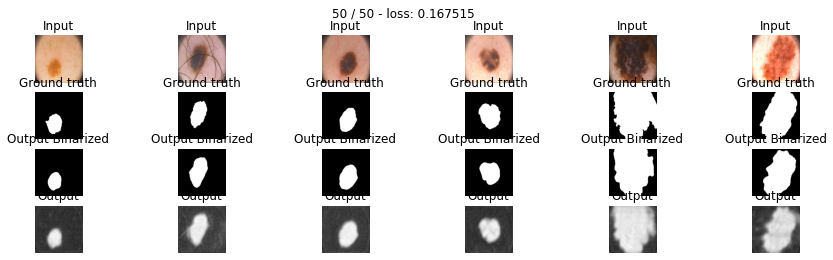

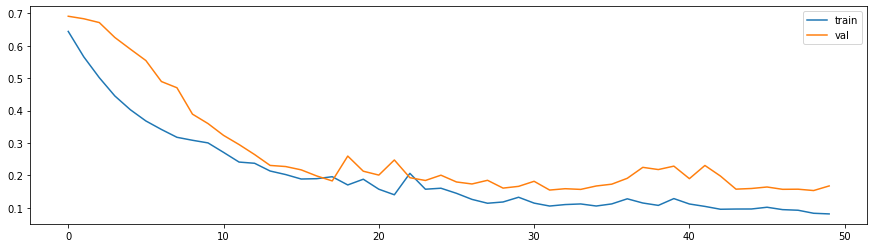

In [18]:
num_epochs=50
train(model=model_segnet_bce, opt=opt_segnet_bce, loss_fn=bce_loss, epochs=num_epochs, data_tr=data_tr, data_val=data_val)

In [19]:
# axes:
# 0: batch
# 1: channels
# 2,3 : x,y

In [20]:
score_model(model_segnet_bce, iou_pytorch, data_val)

0.8472243249416351

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [17]:
def dice_loss(y_true, y_pred_logits, eps = 1e-8):
    y_pred = torch.sigmoid(y_pred_logits)
    num = (y_true*y_pred).sum(dim=(2,3))
    den = y_true.sum(dim=(2,3))+y_pred.pow(2).sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()

Проводим тестирование:

In [22]:
model_segnet_dice = SegNet().to(device)
opt_segnet_dice = optim.Adam(model_segnet_dice.parameters(),lr=3e-4)

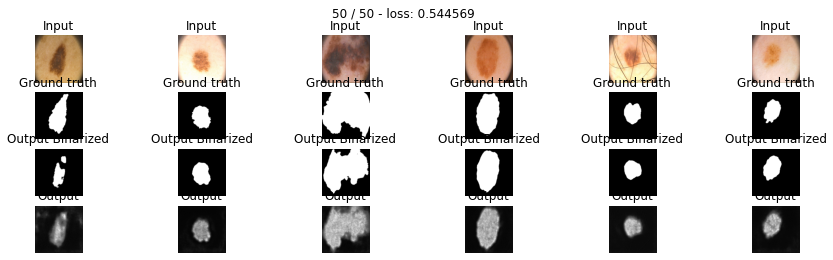

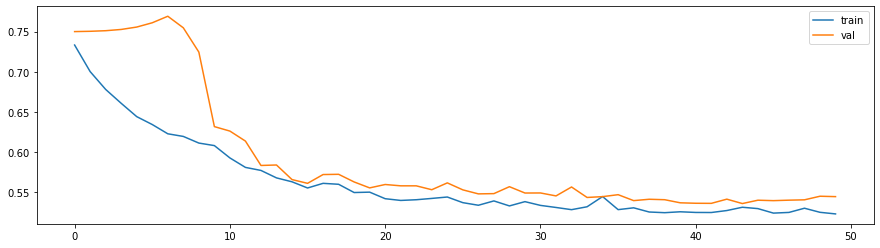

In [23]:
num_epochs=50
train(model=model_segnet_dice, opt=opt_segnet_dice, loss_fn=dice_loss, epochs=num_epochs, data_tr=data_tr, data_val=data_val)

In [24]:
score_model(model_segnet_dice, iou_pytorch, data_val)

0.8498648107051849

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [18]:
def focal_loss(y_true, y_pred_logits, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred_logits).clamp(min=eps,max=1-eps) # hint: torch.clamp
    return -(   (1-y_pred).pow(gamma)*(y_true)*torch.log(y_pred)   +   (y_pred.pow(gamma))*(1-y_true)*torch.log(1-y_pred)   ).mean()

In [26]:
model_segnet_focal = SegNet().to(device)
opt_segnet_focal = optim.Adam(model_segnet_focal.parameters(), lr = 3e-4)

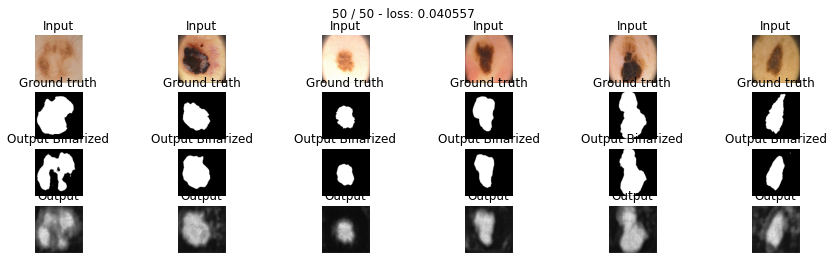

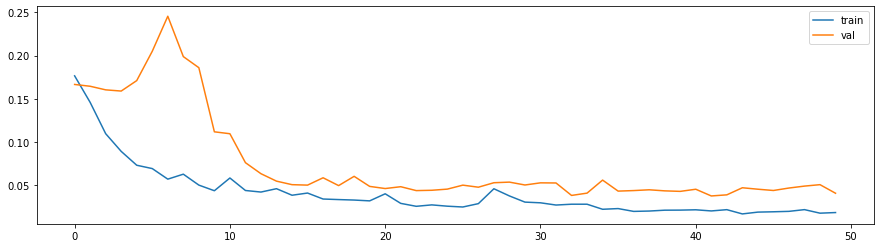

In [27]:
num_epochs = 50
train(model_segnet_focal, opt_segnet_focal, focal_loss, num_epochs, data_tr, data_val)

In [28]:
score_model(model_segnet_focal, iou_pytorch, data_val)

0.8634543418884277

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #ff0000; padding: 10px; background-color: #aa3333">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [19]:
def tversky_loss(y_true, y_pred_logits, eps = 1e-8, beta=0.5):
    y_pred = torch.sigmoid(y_pred_logits)
    intersection = (y_true*y_pred).sum(dim=(2,3))
    num = intersection
    fp = (beta*(1-y_true)*y_pred).sum(dim=(2,3))
    fn = ((1-beta)*y_true*(1-y_pred)).sum(dim=(2,3))
    den = intersection + fp + fn + eps
    return 1-(num/den).mean()

In [30]:
model_segnet_tversky = SegNet().to(device)
opt_segnet_tversky = optim.Adam(model_segnet_tversky.parameters(), lr = 3e-4)

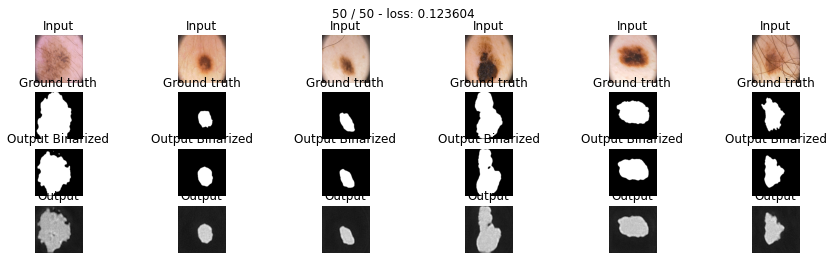

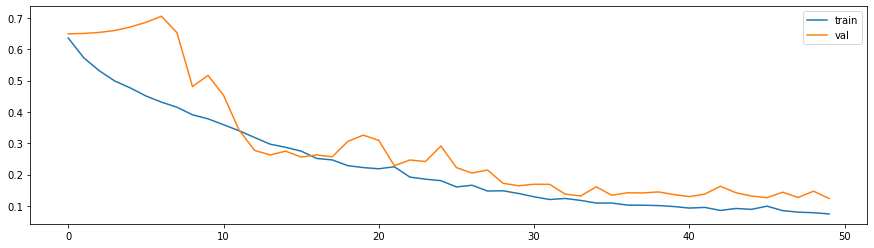

In [31]:
num_epochs = 50
train(model_segnet_tversky, opt_segnet_tversky, tversky_loss, num_epochs, data_tr, data_val)

In [32]:
score_model(model_segnet_tversky, iou_pytorch, data_val)

0.8482548296451569

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

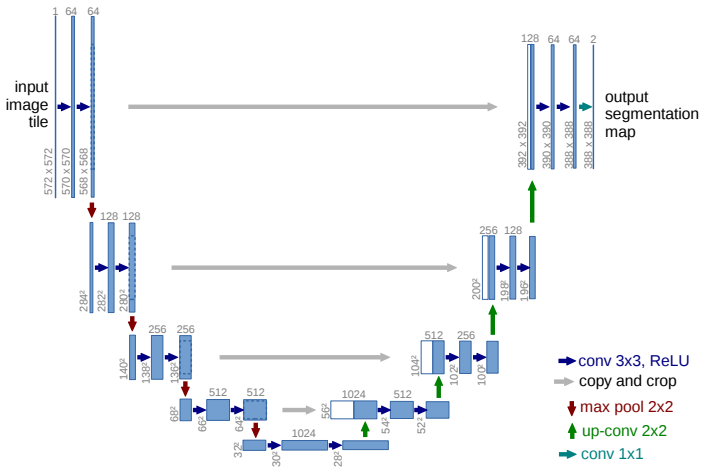

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [20]:
class UNet(SegNet):
    
    def __init__(self):
        
        super().__init__()
        
        # add bottleneck
        
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            self.activation,
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            self.activation,
            
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            self.activation)
        
        # change the in_channels for the first layers in each level because of the new skip connections
        self.dec_conv0[0] = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.dec_conv1[0] = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.dec_conv2[0] = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.dec_conv3[0] = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        
    def forward(self, x):
        
        # encoder
        enc0_raw = self.enc_conv0(x)
        enc0, indices_0 = self.pool0(enc0_raw)
        
        enc1_raw = self.enc_conv1(enc0)
        enc1, indices_1 = self.pool1(enc1_raw)
        
        enc2_raw = self.enc_conv2(enc1)
        enc2, indices_2 = self.pool2(enc2_raw)
        
        enc3_raw = self.enc_conv3(enc2)
        enc3, indices_3 = self.pool3(enc3_raw)

        # bottleneck
        bottleneck = self.bottleneck_conv(enc3)
        
        # decoder
        dec0 = self.dec_conv0(torch.cat((self.upsample0(bottleneck, indices_3), enc3_raw), dim=1))
        dec1 = self.dec_conv1(torch.cat((self.upsample1(dec0, indices_2), enc2_raw), dim=1))
        dec2 = self.dec_conv2(torch.cat((self.upsample2(dec1, indices_1), enc1_raw), dim=1))
        dec3 = self.dec_conv3(torch.cat((self.upsample3(dec2, indices_0), enc0_raw), dim=1))
        
        return dec3

In [34]:
model_unet_bce = UNet().to(device)
opt_unet_bce = optim.Adam(model_unet_bce.parameters(), lr=3e-4)

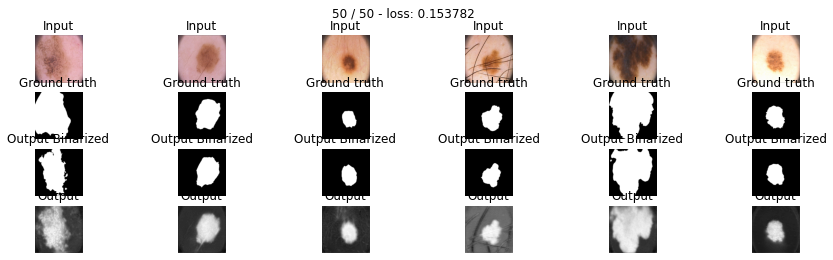

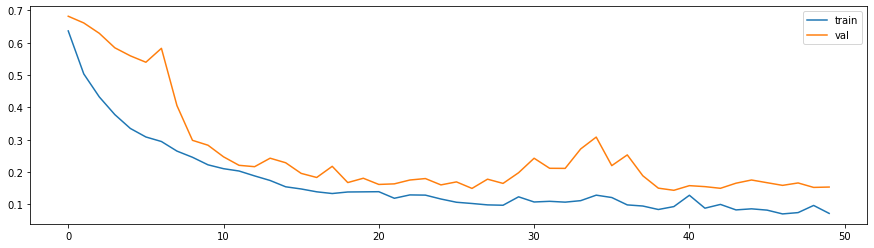

In [35]:
num_epochs = 50
train(model_unet_bce, opt_unet_bce, bce_loss, num_epochs, data_tr, data_val)

In [36]:
score_model(model_unet_bce, iou_pytorch, data_val)

0.8584107756614685

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [21]:
class UNet2(UNet):
    
    def __init__(self):
        
        super().__init__()
        
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, padding_mode='zeros')  # 256 -> 128
        self.pool1 =  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, padding_mode='zeros') # 128 -> 64
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, padding_mode='zeros') # 64 -> 32
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, padding_mode='zeros') # 32 -> 16

        self.upsample0 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1, padding_mode='zeros') # 16 -> 32
        self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, padding_mode='zeros') # 32 -> 64
        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1, padding_mode='zeros')  # 64 -> 128
        self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1, padding_mode='zeros')  # 128 -> 256
        
    def forward(self, x):
        
        # encoder
        enc0_raw = self.enc_conv0(x)
        enc0 = self.pool0(enc0_raw)
        
        enc1_raw = self.enc_conv1(enc0)
        enc1 = self.pool1(enc1_raw)
        
        enc2_raw = self.enc_conv2(enc1)
        enc2 = self.pool2(enc2_raw)
        
        enc3_raw = self.enc_conv3(enc2)
        enc3 = self.pool3(enc3_raw)

        # bottleneck
        bottleneck = self.bottleneck_conv(enc3)
        
        # decoder
        dec0 = self.dec_conv0(torch.cat((self.upsample0(bottleneck), enc3_raw), dim=1))
        dec1 = self.dec_conv1(torch.cat((self.upsample1(dec0), enc2_raw), dim=1))
        dec2 = self.dec_conv2(torch.cat((self.upsample2(dec1), enc1_raw), dim=1))
        dec3 = self.dec_conv3(torch.cat((self.upsample3(dec2), enc0_raw), dim=1))
        
        return dec3

In [38]:
model_unet2_bce = UNet2().to(device)
opt_unet2_bce = optim.Adam(model_unet2_bce.parameters(), lr=3e-4)

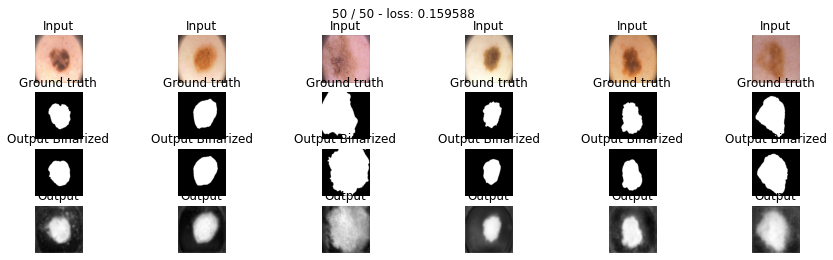

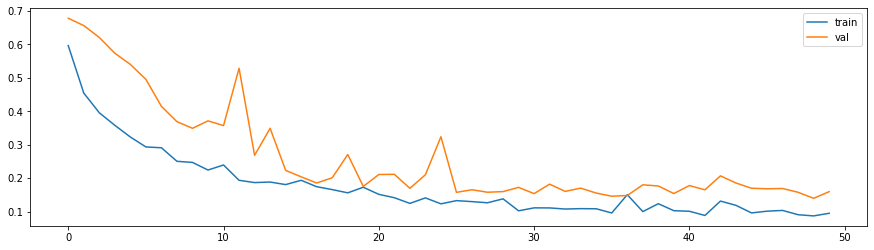

In [39]:
num_epochs = 50
train(model_unet2_bce, opt_unet2_bce, bce_loss, num_epochs, data_tr, data_val)

In [40]:
score_model(model_unet2_bce, iou_pytorch, data_val)

0.845969021320343

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [22]:
class DilatedSegNet(UNet2):
    
    def __init__(self):
        
        super().__init__()
        
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(512),
            self.activation,
            
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            self.activation,
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(512),
            self.activation,
            
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            self.activation,
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0, dilation=1),
            nn.BatchNorm2d(256),
            self.activation)

In [42]:
model_dilatedsegnet_bce = DilatedSegNet().to(device)
opt_dilatedsegnet_bce = optim.Adam(model_dilatedsegnet_bce.parameters(),lr=3e-4)

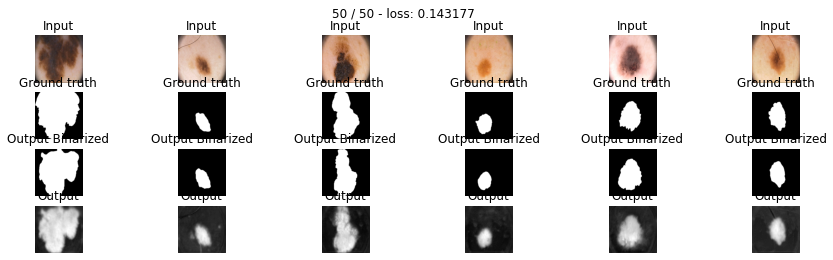

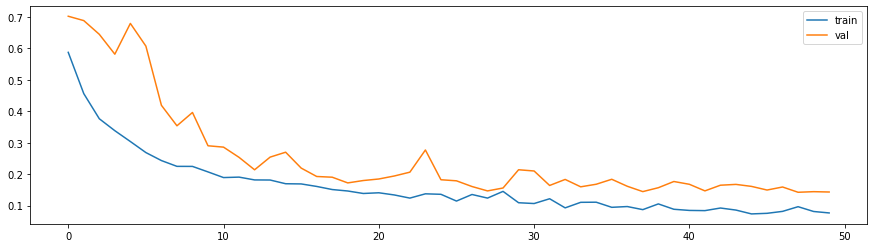

In [43]:
num_epochs = 50
train(model_dilatedsegnet_bce, opt_dilatedsegnet_bce, bce_loss, num_epochs, data_tr, data_val)

In [44]:
score_model(model_dilatedsegnet_bce, iou_pytorch, data_val)

0.8714908361434937

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



In [29]:
clean_my_cuda()

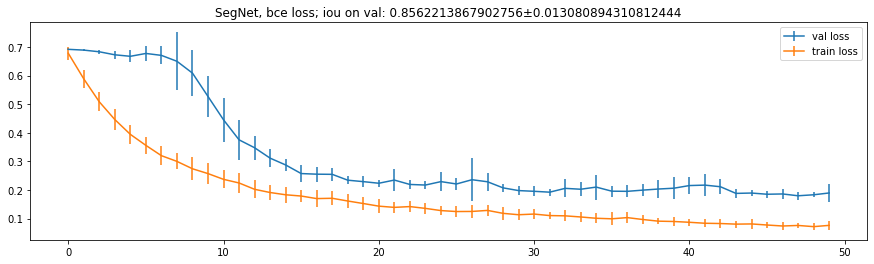

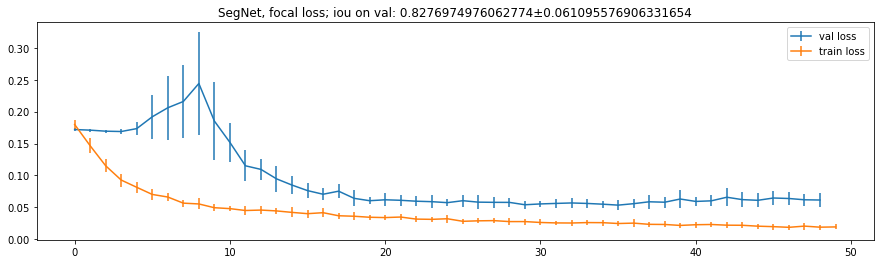

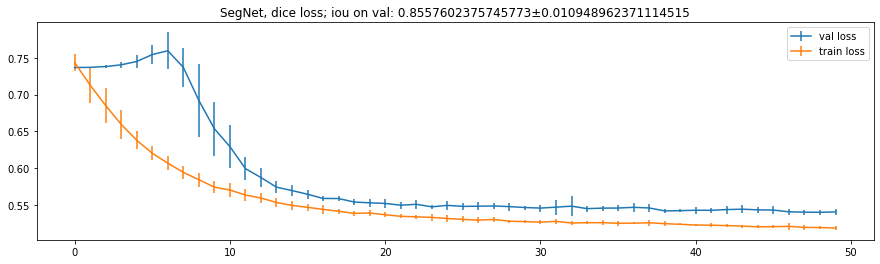

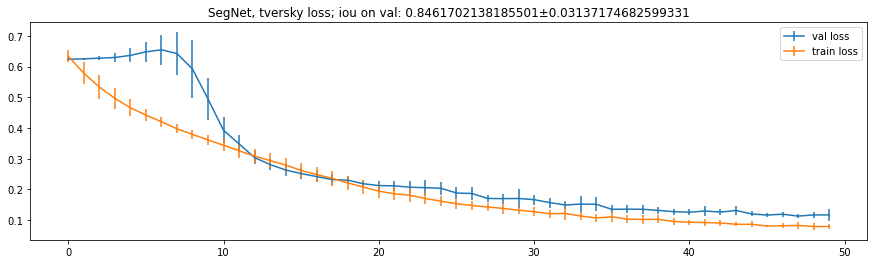

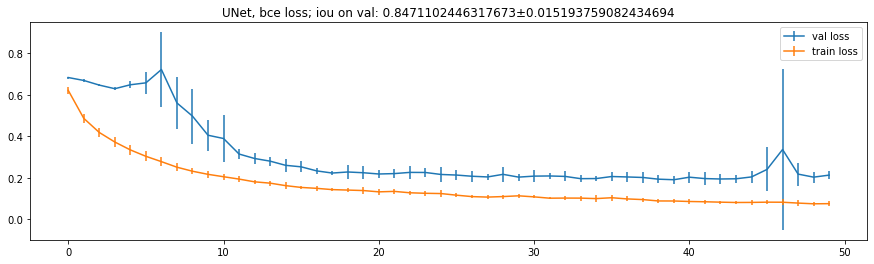

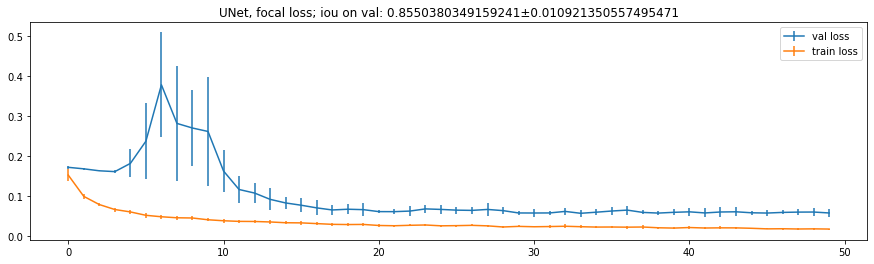

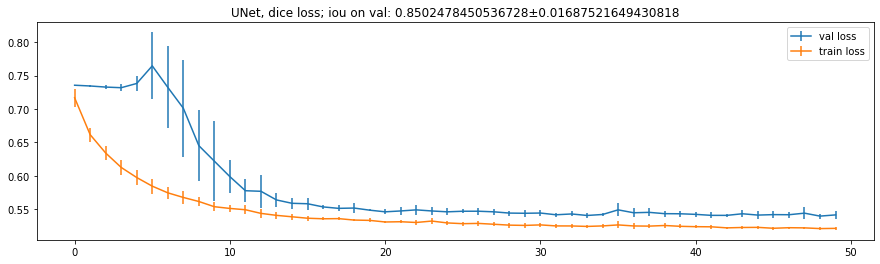

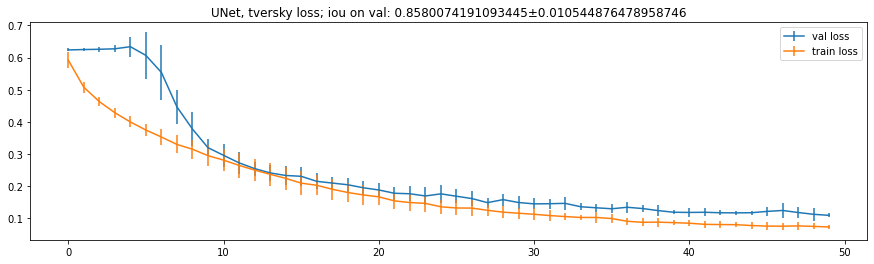

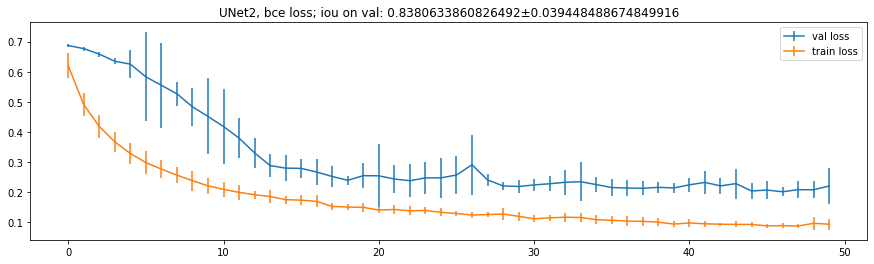

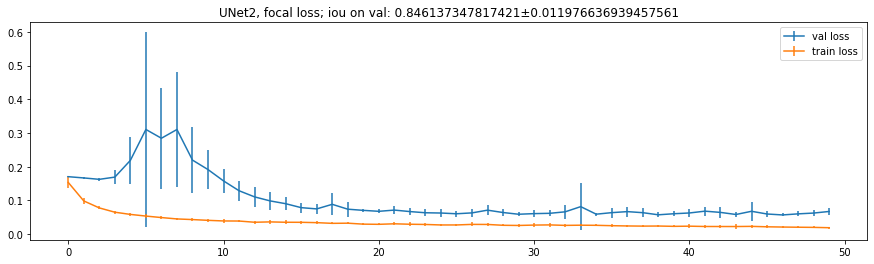

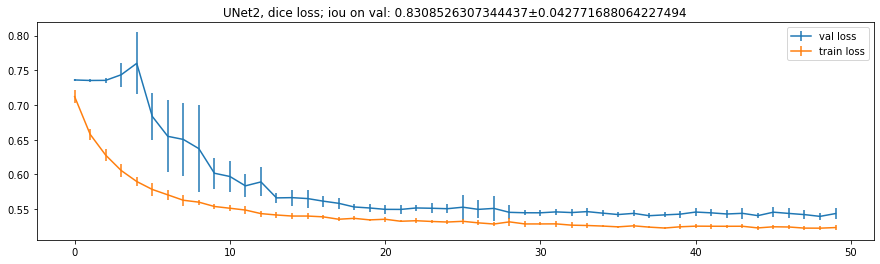

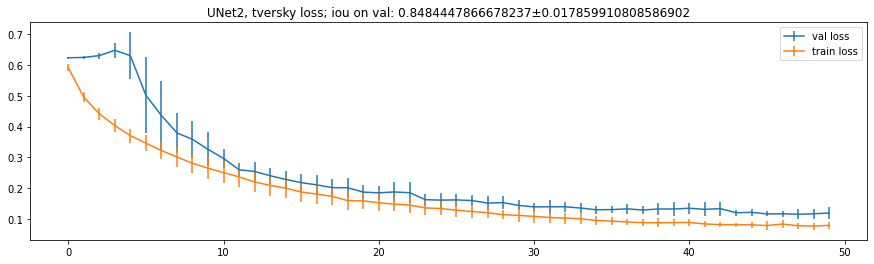

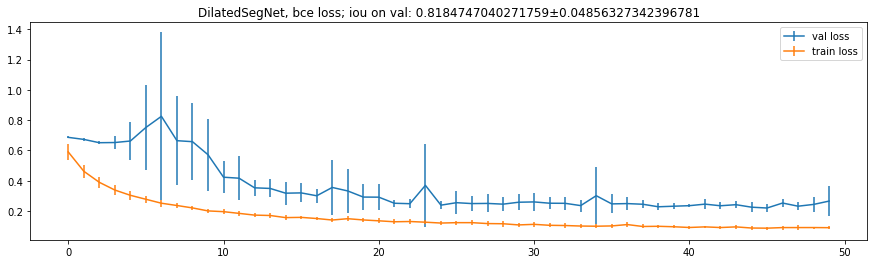

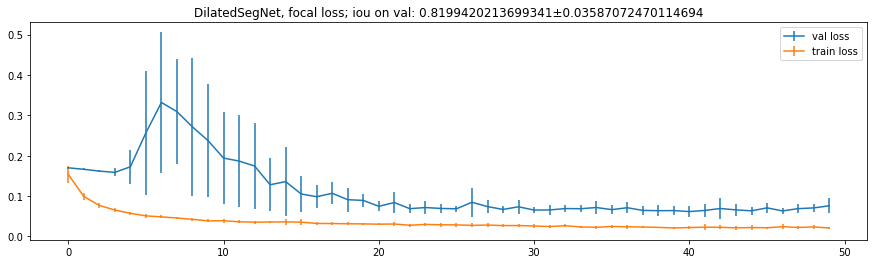

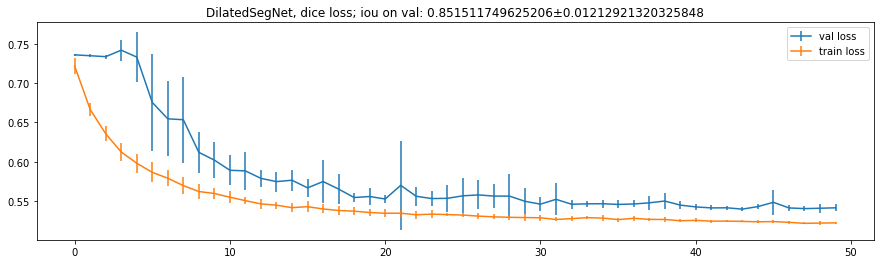

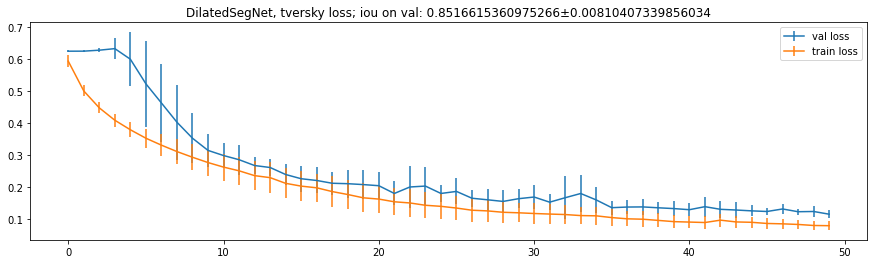

In [46]:
num_epochs = 50
num_tests = 10
archs = {'SegNet': SegNet, 'UNet': UNet, 'UNet2': UNet2, 'DilatedSegNet': DilatedSegNet}
lossfns = {'bce': bce_loss, 'focal':focal_loss, 'dice':dice_loss, 'tversky': tversky_loss}

best_average_score = 0
average_scores = {}
best_combo = None

for arch_name in archs:
    for lossfn_name in lossfns:
        train_losses = []
        val_losses = []
        val_scores = []
        for _ in range(num_tests):
            
            model = archs[arch_name]().to(device)
            opt = optim.Adam(model.parameters(),lr=3e-4)
            
            loss_pair = train(model, opt, lossfns[lossfn_name], num_epochs, data_tr, data_val, verbose=False, return_losses=True)
            train_losses.append(np.asarray(loss_pair['train']))
            val_losses.append(np.asarray(loss_pair['val']))
            
            val_scores.append(score_model(model, iou_pytorch, data_val))
            
            clean_my_cuda()
        
        val_scores = np.asarray(val_scores)
        average_score = val_scores.mean()
        average_scores[arch_name+'_'+lossfn_name] = val_scores.mean()

        if average_score > best_average_score:
            best_average_score = average_score
            best_combo = {'arch_name':arch_name, 'lossfn_name':lossfn_name}

        # усредним графики
        
        val_losses = np.asarray(val_losses)
        train_losses = np.asarray(train_losses)
        
        plt.errorbar(range(num_epochs), val_losses.mean(axis=0), yerr=val_losses.std(axis=0), label='val loss')
        plt.errorbar(range(num_epochs), train_losses.mean(axis=0), yerr=train_losses.std(axis=0), label='train loss')
        
        plt.legend()
        plt.title(arch_name+', '+lossfn_name+' loss'+'; iou on val: %.3e ± %.3e' % (average_score, val_scores.std()))
        plt.show()

In [95]:
best_combo

{'arch_name': 'UNet', 'lossfn_name': 'tversky'}

In [ ]:
model = archs[best_combo['arch_name']]().to(device)
opt = optim.Adam(model.parameters(),lr=3e-4)
lossfn = lossfns[best_combo['lossfn_name']]
sched = optim.lr_scheduler.ReduceLROnPlateau(opt)

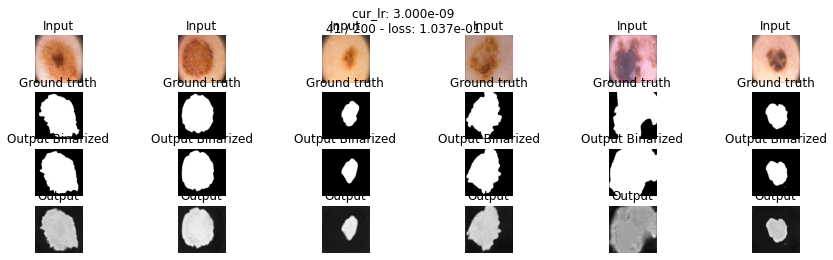

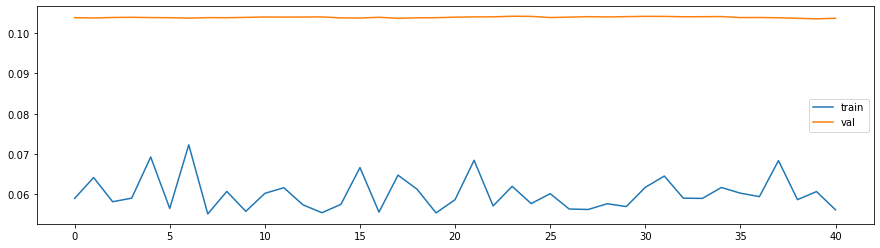

KeyboardInterrupt: 

In [93]:
num_epochs = 300
train(model, opt, lossfn, num_epochs, data_tr, data_val, scheduler=sched)

In [94]:
score_model(model, iou_pytorch, data_ts)

0.8914052844047546